In [1]:
import os
import sys

sys.path.append("..")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import HH4b.utils as utils
import HH4b.plotting as plotting
from HH4b.postprocessing.postprocessing import Region, weight_shifts
from HH4b.utils import ShapeVar, CUT_MAX_VAL
from HH4b.hh_vars import samples, data_key, bg_keys, sig_keys
from sklearn.metrics import roc_curve, auc

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})

In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
year = "2022EE"

samples_year = samples[year].copy()

MAIN_DIR = "/ceph/cms/store/user/dprimosc/bbbb/skimmer"
# this is the directory to the files

tag = "24Sep3_v12_private_signal"
path_to_dir = f"{MAIN_DIR}/{tag}/"

# define dictionary with directories of files (this can be configured in a yaml file later in the script)
sig_keys = ["hh4b"]
for key in list(samples_year.keys()):
    if key not in ["qcd", "ttbar"] + sig_keys:
        del samples_year[key]

sample_dirs = {path_to_dir: samples_year}

# make plot and template directory
date = "24Sep6"  # date of plotting
plot_dir = f"{MAIN_DIR}/plots/PostProcessing/{date}/{year}"
template_dir = f"templates/{date}/"  # why needed?
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {template_dir}/cutflows/{year}")

In [4]:
# Checking contents of parquet files
def examine_parquet_files(dir_path):

    file_printed = False
    for file_name in os.listdir(dir_path):
        if file_printed:
            break

        if file_name.endswith(".parquet"):
            file_printed = True

            file_path = os.path.join(dir_path, file_name)

            try:
                # Read the parquet file into a DataFrame
                pdf = pd.read_parquet(file_path)

                # Display file information
                print(f"\nContents of {file_path}:")
                print("Columns:")
                for column in pdf.columns:
                    if column[1] == 0:
                        # print column and number of entries
                        print(f"{column[0]}: {pdf[column[0]].shape[1]}")

            except Exception as e:
                print(f"Error reading {file_path}: {e}")


test_directory = "/ceph/cms/store/user/dprimosc/bbbb/skimmer/24Sep3_v12_private_signal/2022EE/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/parquet"
print(test_directory)
examine_parquet_files(test_directory)

/ceph/cms/store/user/dprimosc/bbbb/skimmer/24Sep3_v12_private_signal/2022EE/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/parquet

Contents of /ceph/cms/store/user/dprimosc/bbbb/skimmer/24Sep3_v12_private_signal/2022EE/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/parquet/out_3.parquet:
Columns:
GenHiggsEta: 2
GenHiggsPhi: 2
GenHiggsMass: 2
GenHiggsPt: 2
GenbEta: 4
GenbPhi: 4
GenbMass: 4
GenbPt: 4
ak8FatJetHiggsMatch: 2
ak8FatJetHiggsMatchIndex: 2
ak8FatJetNumBMatchedH1: 2
ak8FatJetNumBMatchedH2: 2
ak8FatJetMaxdRH1: 2
ak8FatJetMaxdRH2: 2
bbFatJetEta: 2
bbFatJetPhi: 2
bbFatJetMass: 2
bbFatJetPt: 2
bbFatJetMsd: 2
bbFatJetPNetTXbb: 2
bbFatJetPNetTXjj: 2
bbFatJetPNetTQCD: 2
bbFatJetPNetQCD1HF: 2
bbFatJetPNetQCD2HF: 2
bbFatJetPNetQCD0HF: 2
bbFatJetPNetMass: 2
bbFatJetPNetMassRaw: 2
bbFatJetTau3OverTau2: 2
bbFatJetrawFactor: 2
bbFatJetMatchedGenJetPt: 2
bbFatJetPNetMassLegacy: 2
bbFatJetPNetTXbbLegacy: 2
bbFatJetPNetPXbbLegacy: 2
bbFatJetPNetPQCDLegacy: 2
bbFatJetPNetPQCDbL

In [5]:
# separate signal and background for to fit with load_samples function
bkg_sample_dirs = {}
sig_sample_dirs = {}

for path, datasets in sample_dirs.items():
    bkg_sample_dirs[path] = {"qcd": datasets.get("qcd", []), "ttbar": datasets.get("ttbar", [])}
    sig_sample_dirs[path] = {"hh4b": datasets.get("hh4b", [])}

In [6]:
# filters, currently just a placeholder value to apply no real filter
# TODO: what weights to use
filters = [
    [
        ("('ak8FatJetPt',0)", ">=", 400)("('ak8FatJetPt',0)", "<=", 600)(
            "('ak8FatJetPt',1)", ">=", 400
        )("('ak8FatJetPt',1)", "<=", 600)("('ak8FatJetMsd',0)", ">=", 50)(
            "('ak8FatJetMsd',0)", "<=", 250
        )(
            "('ak8FatJetMsd',1)", ">=", 50
        )(
            "('ak8FatJetMsd',1)", "<=", 250
        )
    ],
]

# background columns to load
bkg_load_columns = [
    ("weight", 1),
    ("ak8FatJetPNetTXbb", 2),
    ("ak8FatJetPNetTXbbLegacy", 2),
    ("ak8FatJetPt", 2),
    ("ak8FatJetMsd", 2),
]

# signal columns to load
sig_load_columns = [
    ("weight", 1),
    ("ak8FatJetPNetTXbb", 2),
    ("ak8FatJetPNetTXbbLegacy", 2),
    ("ak8FatJetPt", 2),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetHiggsMatchIndex", 2),
    ("ak8FatJetNumBMatchedH1", 2),
    ("ak8FatJetNumBMatchedH2", 2),
]

# reformat into ("column name", "idx") format for reading multiindex columns
bkg_columns = []
for key, num_columns in bkg_load_columns:
    for i in range(num_columns):
        bkg_columns.append(f"('{key}', '{i}')")

sig_columns = []
for key, num_columns in sig_load_columns:
    for i in range(num_columns):
        sig_columns.append(f"('{key}', '{i}')")

# save cutflow as pandas table
# TODO: check this is running correctly
cutflow = pd.DataFrame(index=list(samples_year.keys()))

# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples_dict in bkg_sample_dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        # load background
        **utils.load_samples(
            input_dir,
            samples_dict,
            year,
            filters=filters,
            columns=bkg_columns,
            reorder_txbb=False,
            variations=False,
            # columns_mc=utils.format_columns(load_columns_mc),
        ),
    }
for input_dir, samples_dict in sig_sample_dirs.items():
    events_dict = {
        **events_dict,
        # load signal
        **utils.load_samples(
            input_dir,
            samples_dict,
            year,
            filters=filters,
            columns=sig_columns,
            reorder_txbb=False,
            variations=False,
            # columns_mc=utils.format_columns(load_columns_mc),
        ),
    }

utils.add_to_cutflow(events_dict, "Preselection", "finalWeight", cutflow)
print("\n", cutflow)

Loading QCD_HT-1200to1500
Loaded QCD_HT-1200to1500                                 : 13715549 entries
Loading QCD_HT-100to200
Loaded QCD_HT-100to200                                   : 8 entries
Loading QCD_HT-1500to2000
Loaded QCD_HT-1500to2000                                 : 15374273 entries
Loading QCD_HT-600to800
Loaded QCD_HT-600to800                                   : 536811 entries
Loading QCD_HT-200to400
Loaded QCD_HT-200to400                                   : 30 entries
Loading QCD_HT-2000
Loaded QCD_HT-2000                                       : 18578670 entries
Loading QCD_HT-800to1000
Loaded QCD_HT-800to1000                                  : 3896199 entries
Loading QCD_HT-400to600
Loaded QCD_HT-400to600                                   : 31979 entries
Loading QCD_HT-1000to1200
Loaded QCD_HT-1000to1200                                 : 9059221 entries
Loading TTto4Q
Loaded TTto4Q                                            : 5858667 entries
Loading GluGlutoHHto4B_kl-1

In [12]:
indexak8 = events_dict["hh4b"][
    "ak8FatJetHiggsMatchIndex"
].to_numpy()  # index of higgs matched to jet
nbh1ak8 = events_dict["hh4b"][
    "ak8FatJetNumBMatchedH1"
].to_numpy()  # number of bquarks matched to H1
nbh2ak8 = events_dict["hh4b"][
    "ak8FatJetNumBMatchedH2"
].to_numpy()  # number of bquarks matched to H2

matched_to_h1 = (indexak8 == 0) & (nbh1ak8 == 2)
matched_to_h2 = (indexak8 == 1) & (nbh2ak8 == 2)
matchedak8 = matched_to_h1 | matched_to_h2  # 2 b quarks matched to higgs (ak8 jet 0, ak8 ket 1)

# TODO: revise how this is done, something is still not right
pdf = pd.DataFrame(matchedak8, columns=["j1", "j2"])
mask = pd.concat([pdf["j1"], pdf["j2"]], ignore_index=True)
sig_true = np.ones(2 * len(events_dict["hh4b"]))
sig_true[~mask] = 0
print(matchedak8)

[[ True  True]
 [ True False]
 [ True  True]
 ...
 [ True False]
 [ True  True]
 [ True False]]


In [8]:
# Need to split up jets for object level analysis
# Just concatenate the two rows

In [9]:
# jet = 1  # second jet
# we use both jets
sig_key = "hh4b"
bg_keys = ["qcd", "ttbar"]
# bg_skip = 1

y_true = np.concatenate(
    [
        sig_true,
        np.zeros(
            np.sum(2 * len(events_dict[bg_key]) for bg_key in bg_keys)
        ),  # factor 2 needed bc we use both jets indivdiually
    ]
)
# print(y_true[np.sum(sig_cut):])

weights = np.concatenate(
    [events_dict[sig_key]["finalWeight"]]
    + [events_dict[sig_key]["finalWeight"]]
    + [events_dict[bg_key]["finalWeight"] for bg_key in bg_keys]
    + [events_dict[bg_key]["finalWeight"] for bg_key in bg_keys],
)

# following needs to match structure of weights
scores = np.concatenate(
    [events_dict[sig_key]["ak8FatJetPNetTXbb"][jet] for jet in (0, 1)]
    + [events_dict[bg_key]["ak8FatJetPNetTXbb"][0] for bg_key in bg_keys]
    + [events_dict[bg_key]["ak8FatJetPNetTXbb"][1] for bg_key in bg_keys],
)

legacy_scores = np.concatenate(
    [events_dict[sig_key]["ak8FatJetPNetTXbbLegacy"][jet] for jet in (0, 1)]
    + [events_dict[bg_key]["ak8FatJetPNetTXbbLegacy"][0] for bg_key in bg_keys]
    + [events_dict[bg_key]["ak8FatJetPNetTXbbLegacy"][1] for bg_key in bg_keys],
)

/tmp/ipykernel_3631178/2667289319.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(2 * len(events_dict[bg_key]) for bg_key in bg_keys)


In [10]:
fpr, tpr, thresholds = roc_curve(y_true, scores, sample_weight=weights)
roc = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds, "label": "v12"}

legacy_fpr, legacy_tpr, legacy_thresholds = roc_curve(y_true, legacy_scores, sample_weight=weights)
legacy_roc = {
    "fpr": legacy_fpr,
    "tpr": legacy_tpr,
    "thresholds": legacy_thresholds,
    "label": "Legacy",
}

rocs = {
    "V12 ROC": {"roc_1": roc},
    "Legacy ROC": {"roc_2": legacy_roc},
}

TypeError: unsupported operand type(s) for /: 'str' and 'str'

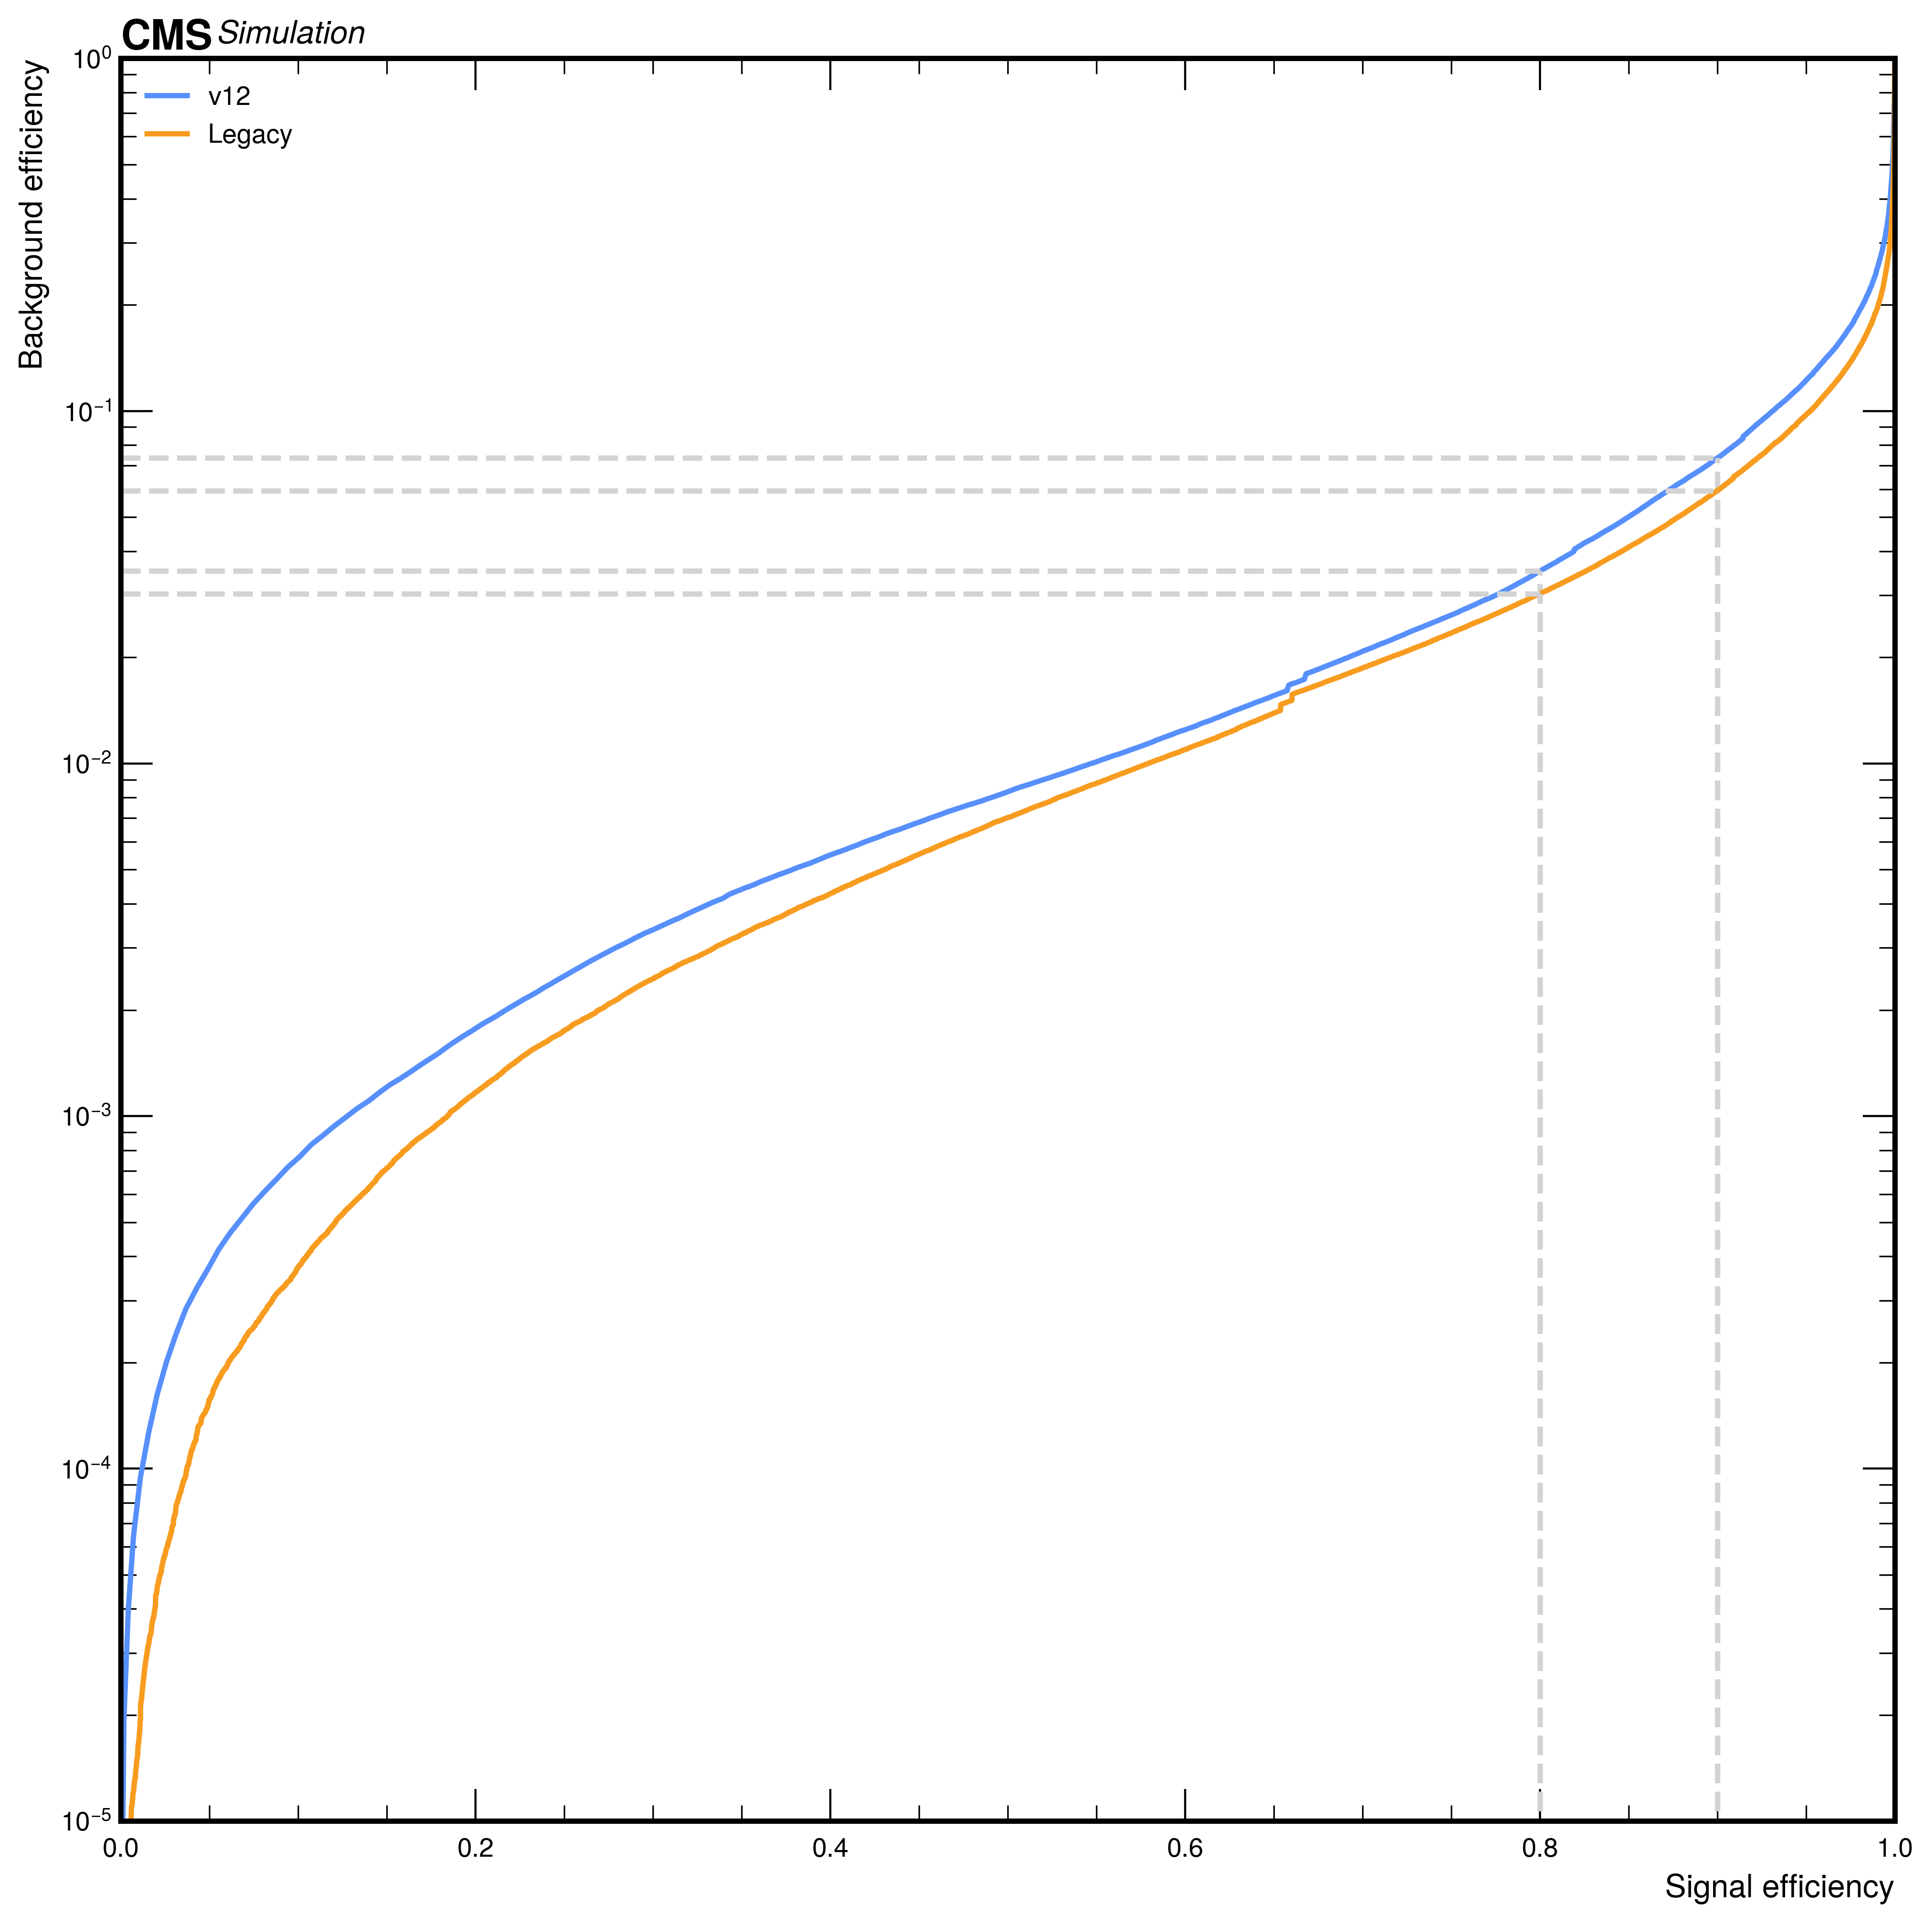

In [11]:
plotting.multiROCCurveGrey(
    rocs=rocs,
    sig_effs=[0.8, 0.9],  # Thresholds for signal efficiency lines
    xlim=[0, 1],
    ylim=[1e-5, 1],
    plot_dir=plot_dir,
    name="ak8FatJet12ROC_Comparison",
    show=True,
)